In [1]:
import pandas as pd
import json

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
  'font.size': 8,
  'text.usetex': True,
  'text.latex.preamble': r'\usepackage{amsmath}',
  'pgf.texsystem': "pdflatex",
  'pgf.preamble': r'\usepackage{amsfonts}',
  #"font.family": "serif",
  #"pgf.rcfonts": False,
})

In [48]:
fig_width=6
fig_height=1.5

func_key = "function_name"
dataset_key = "dataset"
dataset_size_key = "dataset_elem_count"
probing_dist_key = "probing_dist"
throughput_key = "throughput" 

In [3]:
color_i = 0
colors = {}
def get_color(fun):
    global color_i
    global colors
    
    key = fun.lower()
    if key not in colors:
        options = list(mcolors.TABLEAU_COLORS) + list(mcolors.BASE_COLORS)[0:-1]
        colors[key] = options[color_i % len(options)]
        color_i += 1
    return colors[key]

def reset_colors():
    global color_i
    global colors
    color_i = 0
    colors = {}

In [33]:
def dataset_name(d):
    return {'amzn': "amazon", 
            'fb': "facebook", 
            'gap_10': "gapped 10%",
            'osm': "open street map",
            'seq': "sequential",
            'normal': "normal",
            'uniform': "uniform",
            'wiki': "wikipedia"}[d]

In [31]:
results_file = f"../results.json"
with open (results_file) as file:
    data = json.load(file)
    df = pd.json_normalize(data, "benchmarks")

In [83]:
th_df = df[(df["name"].str.startswith("LookupTime")) & (df["run_type"] == "aggregate") & (df["aggregate_name"] == "median")].copy(deep=True)
th_df[func_key] = th_df["label"].apply(lambda x : x.split(":")[0])
th_df[dataset_key] = th_df["label"].apply(lambda x : dataset_name(x.split(":")[1]))
th_df[probing_dist_key] = th_df["label"].apply(lambda x : x.split(":")[2])
th_df[throughput_key] = th_df.apply(lambda x : 10**9 / x["cpu_time"], axis=1)
th_df[[func_key, "cpu_time", throughput_key]]

,function_name,cpu_time,throughput
84,DoNothingHash,12.220576,8.182920e+07
90,DoNothingHash,12.634621,7.914760e+07
96,DoNothingHash,12.729997,7.855461e+07
102,DoNothingHash,13.024753,7.677689e+07
108,DoNothingHash,13.024100,7.678074e+07
...,...,...,...
2088,MapOMPHF,446.251212,2.240890e+06
2094,MapOMPHF,29.954997,3.338341e+07
2100,MapOMPHF,77.694330,1.287095e+07
2106,MapOMPHF,144.908921,6.900886e+06


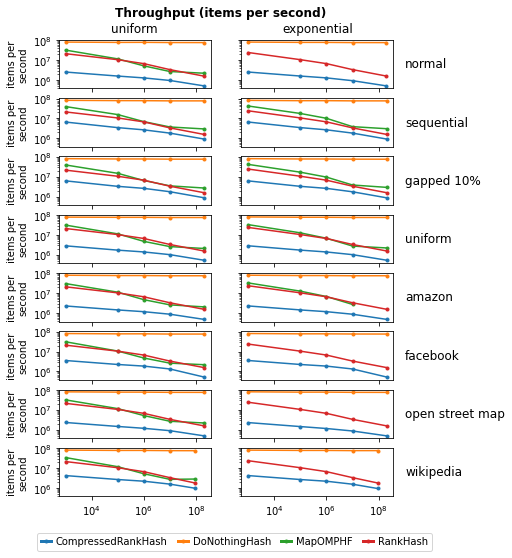

In [99]:
def plot_throughput(data):
    reset_colors()
    
    dists = set(data[probing_dist_key])
    
    rows = 8
    cols = len(dists)
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width, rows*fig_height*0.7), sharex=True, sharey=True)

    data = data.sort_values(by=[func_key, dataset_size_key])
    for i, (dataset, df) in enumerate(data.groupby([dataset_key], sort=False)):
        pad = 7.5
        axs[i][-1].annotate(
            dataset, 
            xy=(0, 0.5),
            xytext=(160 + axs[i][-1].yaxis.labelpad + pad, 0),
            xycoords=axs[i][-1].yaxis.label, 
            textcoords='offset points',
            size='large', 
            ha='left', 
            va='center',
            rotation=0
        )
        axs[i][0].set_ylabel("items per\nsecond")
        for j, (probing_dist, df) in enumerate(df.groupby([probing_dist_key], sort=False)):            
            ax = axs[i][j]

            ax.set_xscale('log')
            ax.set_yscale('log')
#             if i == rows - 1:
#                 ax.set_xlabel("dataset size")
    
            for k, (name, df) in enumerate(df.groupby([func_key], sort=False)):
                ax.plot(dataset_size_key, throughput_key, data=df, color=get_color(name), label=name, linewidth=1.5, marker='.')
                
            if i == 0:
                # ax.set_ylabel("normalized entries per slot")
                ax.annotate(probing_dist, 
                            xy=(0.5, 1), 
                            xytext=(0, pad), 
                            xycoords='axes fraction', 
                            textcoords='offset points', 
                            size='large', 
                            ha='center', 
                            va='baseline',
                           )

    h, l = axs[0][0].get_legend_handles_labels()
    legend = fig.legend(h, l, 
               loc='center right',
               bbox_to_anchor=(1.0, 0.05),
               ncol=4, 
               borderpad=0.4, 
               labelspacing=0.2, 
               handlelength=1.0, 
               handletextpad=0.5, 
               columnspacing=1.0
              )
    for line in legend.get_lines():
        line.set_linewidth(3.0)
                
    # overall title
    fig.suptitle(f"Throughput (items per second)", y=0.935, fontweight="bold")
    
    fig.savefig(f"throughput.pdf", bbox_inches="tight", dpi=300)
    fig.savefig(f"throughput.pgf", bbox_inches="tight", dpi=300)
    
plot_throughput(th_df)